<html> 
<body> 
<p><font size= "4" face="verdana" color="green">Project: Image Classification and Regression  MVA - CentraleSupelec</font> </p>
</body> 
</html>


                      
                            
                

<html> 
<body>
    
 <p><font size="4">
    <p><u><b><i> 1)-Data type generating </i></b> </u></p>
    </font></p>
</body>
</html>

<html> 
<body>
    
 <p><font size="4"> The following codes output three simple goemetrical shapes such as triangle, rectangle 
and disk. These shapes will be used throughout all what follow in order to solve problems as classification, regression and denoising </font></p>

</body>
</html>

In [1]:
# Project: Image Classification and Regression  MVA - CentraleSupelec
#1)-Data type generating



#The following codes output three simple goemetrical shapes such as triangle, rectangle 
#and disk. These shapes will be used 
#throughout all what follow in order to solve problems as classification, regression and denoising



from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import LocallyConnected2D

from keras.models import Model
from keras.layers import AveragePooling2D
from keras.backend import pool2d
from keras.layers import UpSampling2D
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Add
from keras.optimizers import Adam

import  numpy as np
import  matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline



# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]
                                                     
#im = generate_a_rectangle(10, True)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
#im = generate_a_disk(10)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
#im, v] = generate_a_triangle(20, False)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()
    
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]
                                                     
                                                     
                                                     


                                                                                                                                        
                                                                         




Using TensorFlow backend.


<html> 
<body>
    
 <p><font size="4">
    <p><u><b><i> 2)-Simple classification </i></b> </u></p>
    </font></p>
</body>
</html>

<html> 
<body>
<p><font size="4"> We build and train a linear classifier in Keras to classify a image into one of the three possible categories (i.e. rectangle, disk, triangle). We will use first the stochastic gradient descent optimizer, then the Adam optimizer
</font></p>
</body>
</html>

<html> 
<body>
<p><font size="4"> 
2-1)-Case of SGD optimizer
</font></p>
</body>
</html>

In [2]:
#2)-Simple classification



#We build and train a linear classifier in Keras to classify a image into one of the three possible
#categories (i.e. rectangle, disk, triangle). We will use first the stochastic gradient descent optimizer,
#then the Adam optimizer


#2-1)-Case of SGD optimizer

#generating training set of images of simple geometric shapes
[X_train, Y_train] = generate_dataset_classification(300, 20)

# Transforming labels 0, 1 and 2 to biraries arrays, in order to make binary classification

Y_binary = to_categorical(Y_train)

#Linear Model

model = Sequential()
model.add(Dense(input_dim=5184, activation="softmax", units=3, kernel_initializer="normal"))

#Defining the optimization method(stochastic gradient descent optimizer)

model.compile(loss='mse', optimizer='sgd')

model.fit(X_train, Y_binary, epochs=30, batch_size=32)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Epoch 1/30
300/300 [==============================] - 0s 388us/step - loss: 0.3225
Epoch 2/30
300/300 [==============================] - 0s 102us/step - loss: 0.2918
Epoch 3/30
300/300 [==============================] - 0s 90us/step - loss: 0.2653
Epoch 4/30
300/300 [==============================] - 0s 101us/step - loss: 0.2309
Epoch 5/30
300/300 [==============================] - 0s 108us/step - loss: 0.1997
Epoch 6/30
300/300 [==============================] - 0s 106us/step - loss: 0.1810
Epoch 7/30
300/300 [==============================] - 0s 124us/step - loss: 0.1616
Epoch 8/30
300/300 [==============================] - 0s 115us/step - loss: 0.1688
Epoch 9/30
300/300 [==============================] - 0s 95us/step - loss: 0.1378
Epoch 10/30
300/300 [==============================] - 0s 90us/step - loss: 0.1466
Epoch 11/30
300/300 [===========================

<html> 
<body>
<p><font size="4"> 
2-1-1)-Checking the classifier with SGD optimizer
</font></p>
</body>
</html>

In [3]:
#2-1-1)-Checking the classifier with SGD optimizer

X_test = generate_a_disk()
print(X_test)
print(X_test.shape)
X_test = X_test.reshape(1, X_test.shape[0])
print(X_test.shape)
model.predict(X_test)

[255. 255. 255. ... 255. 255. 255.]
(5184,)
(1, 5184)


array([[0., 1., 0.]], dtype=float32)

<html> 
<body>
<p><font size="4"> 
2-2)-Case of Adam optimizer 
</font></p>
</body>
</html>

In [4]:
#2-2)-Case of Adam optimizer

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, Y_binary, epochs=30, batch_size=32)

Epoch 1/30
300/300 [==============================] - 0s 447us/step - loss: 0.2024
Epoch 2/30
300/300 [==============================] - 0s 134us/step - loss: 0.2124
Epoch 3/30
300/300 [==============================] - 0s 142us/step - loss: 0.1976
Epoch 4/30
300/300 [==============================] - 0s 133us/step - loss: 0.1887
Epoch 5/30
300/300 [==============================] - 0s 133us/step - loss: 0.1781
Epoch 6/30
300/300 [==============================] - 0s 136us/step - loss: 0.1751
Epoch 7/30
300/300 [==============================] - 0s 159us/step - loss: 0.1712
Epoch 8/30
300/300 [==============================] - 0s 150us/step - loss: 0.1694
Epoch 9/30
300/300 [==============================] - 0s 116us/step - loss: 0.1723
Epoch 10/30
300/300 [==============================] - 0s 134us/step - loss: 0.1756
Epoch 11/30
300/300 [==============================] - 0s 135us/step - loss: 0.1705
Epoch 12/30
300/300 [==============================] - 0s 129us/step - loss: 0.1664
E

<html> 
<body>
<p><font size="4"> 
2-2-1)-Checking the classifier with Adam optimizer
</font></p>
</body>
</html>

In [5]:
#2-2-1)-Checking the classifier with Adam optimizer


X_test = generate_a_disk()
print(X_test)
print(X_test.shape)
X_test = X_test.reshape(1, X_test.shape[0])
print(X_test.shape)
model.predict(X_test)

[255. 255. 255. ... 255. 255. 255.]
(5184,)
(1, 5184)


array([[0., 1., 0.]], dtype=float32)


<html> 
<body>
    
 <p><font size="4">
    <p><u><b><i> 3)-Visualization of the Solution </i></b> </u></p>
    </font></p>
</body>
</html>

<html> 
<body>
 <p><font size="4"> We visualize the weights of the linear classifier </font></p>
</body>
</html>

(5184,)


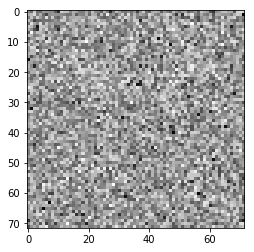

In [6]:
#3)-Visualization of the Solution

#We visualize the weights of the linear classifier


print(model.get_weights()[0][:,0].shape)

plt.imshow(model.get_weights()[0][:,0].reshape(72,72), cmap = cm.Greys)

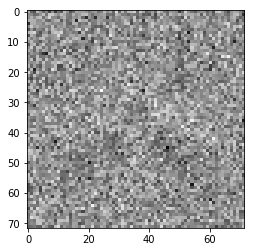

In [7]:
plt.imshow(model.get_weights()[0][:,1].reshape(72,72), cmap = cm.Greys)

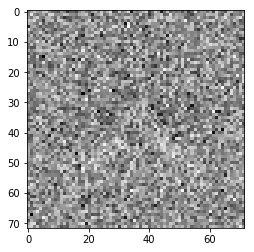

In [8]:
plt.imshow(model.get_weights()[0][:,2].reshape(72,72), cmap = cm.Greys)


<html> 
<body>
    
 <p><font size="4">
    <p><u><b><i> 4)-A More Difficult Classification Problem </i></b> </u></p>
    </font></p>
</body>
</html>

<html> 
<body>
<p><font size="4"> Now, the shapes are allowed to move within the images and change dimensions, which ipplied the use of convolution neural networks.
</font></p>
</body>
</html>

<html> 
<body>
<p><font size="4"> 4-1)-We retrain our linear classifier on new training set of image with shape taking into account. And we add the metrics=[’accuracy’] parameter
when calling the compile function to get the classification error in addition to the loss value.</font></p>
</body>
</html>

In [9]:
#4)-A More Difficult Classification Problem 


#Now, the shapes are allowed to move within the images and
# dimensions, which ipplied the use of convolution neural networks.



#4-1)-We retrain our linear classifier on new training set of 
#image with shape taking into account. And we add the metrics=[’accuracy’] parameter
#when calling the compile function to get the classification error in addition to the loss value.

#generating training set of images of simple geometric shapes
[X_train, Y_train] = generate_dataset_classification(300, 20, True)


# Transforming labels 0, 1 and 2 to biraries arrays, in order to make binary classification

Y_binary = to_categorical(Y_train)

#Linear Model

model = Sequential()
model.add(Dense(input_dim=5184, activation="softmax", units=3, kernel_initializer="normal"))

#Defining the optimization method(stochastic gradient descent optimizer)

model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])

model.fit(X_train, Y_binary, epochs=40, batch_size=32)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Epoch 1/40
300/300 [==============================] - 0s 464us/step - loss: 0.3032 - acc: 0.3333
Epoch 2/40
300/300 [==============================] - 0s 135us/step - loss: 0.2785 - acc: 0.3700
Epoch 3/40
300/300 [==============================] - 0s 114us/step - loss: 0.2917 - acc: 0.3500
Epoch 4/40
300/300 [==============================] - 0s 101us/step - loss: 0.2927 - acc: 0.3767
Epoch 5/40
300/300 [==============================] - 0s 129us/step - loss: 0.2561 - acc: 0.4200
Epoch 6/40
300/300 [==============================] - 0s 139us/step - loss: 0.2562 - acc: 0.4200
Epoch 7/40
300/300 [==============================] - 0s 124us/step - loss: 0.2565 - acc: 0.4300
Epoch 8/40
300/300 [==============================] - 0s 149us/step - loss: 0.2708 - acc: 0.3833
Epoch 9/40
300/300 [==============================] - 0s 187us/step - loss: 0.2473 - acc: 0.4733
Epo

<html> 
<body>
<p><font size="4"> 4-1)-Testing </font></p>
</body>
</html>

In [10]:
[X_test, Y_test] = generate_test_set_classification()
model.evaluate(X_test, Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 134us/step


[0.22583477238814037, 0.5433333325386047]

<html> 
<body>
<p><font size="4"> 4-1)-We train a convolutional (not-to-)deep network on this new dataset </font></p>
</body>
</html>


In [11]:
#4-1)-We train a convolutional (not-to-)deep network on this new dataset

[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_binary = to_categorical(Y_train)
X = [np.expand_dims(np.expand_dims(X_train[i].reshape(72,72), 2), 0) for i in range(300)]
Y = np.expand_dims(Y_binary, axis=1)
print(X[0], X[0].shape)
print(Y[0], Y[0].shape)

model_input = Input(shape = (72, 72, 1))
conv1 = Conv2D(16, 5, padding='same', activation="softmax")(model_input)
print(conv1.shape)
pool1 = MaxPooling2D(pool_size=(24, 24), padding = "valid")(conv1)
print(pool1.shape)
flatten = Flatten()(pool1)
dense1 = Dense(3, activation = 'relu')(flatten)
mod= Model(model_input, dense1)
mod.summary()
### Defining the optimization method(stochastic gradient descent optimizer)
for i in range(1):
    mod.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
    mod.fit(X[i], Y[i], epochs=4, batch_size=4)



Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
[[[[0.96609374]
   [0.93900169]
   [0.98642444]
   ...
   [0.95609019]
   [0.99360517]
   [0.9613536 ]]

  [[0.93527722]
   [0.99067896]
   [0.99043851]
   ...
   [0.95145456]
   [0.94971097]
   [0.99527181]]

  [[0.99997895]
   [0.95960149]
   [0.95410403]
   ...
   [0.99849493]
   [0.98004909]
   [0.95457498]]

  ...

  [[0.94927541]
   [0.93977508]
   [0.99849083]
   ...
   [0.9926464 ]
   [0.95904846]
   [0.99035363]]

  [[0.94273567]
   [0.95301136]
   [0.94592699]
   ...
   [0.97170475]
   [0.99632669]
   [0.99809867]]

  [[0.94689758]
   [0.97251392]
   [0.95661843]
   ...
   [0.95514528]
   [0.95217142]
   [0.96325642]]]] (1, 72, 72, 1)
[[0. 0. 1.]] (1, 3)
(?, 72, 72, 16)
(?, 3, 3, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 7

<html> 
<body>
    
 <p><font size="4">
    <p><u><b><i> 5)-A Regression Problem </i></b> </u></p>
    </font></p>
</body>
</html>


<html> 
<body>
<p><font size="4"> 5-1)-The task now is to predict the image locations of the vertices of a triangle, given an image of this
triangle. </font></p>
</body>
</html>

<html> 
<body>
<p><font size="4"> 5-1-1)-We visualize a training sample (or a prediction) by calling the visualize_prediction.
function</font></p>
</body>
</html>

In [12]:
#5)-A Regression Problem

#5-1)-The task now is to predict the image locations of the vertices of a triangle, given an image of this
#triangle


 #5-1-1)-We visualize a training sample (or a prediction) by calling the visualize_prediction.
#function

X_train, Y_train] = generate_dataset_regression(300, 20)
visualize_prediction(X_train[2], Y_train[2])

SyntaxError: invalid syntax (<ipython-input-12-9076d40d14cd>, line 10)

<html> 
<body>
<p><font size="4"> 5-1-2)-We Build and train a regressor on the regression data.</font></p>
</body>
</html>

In [ ]:
#5-1-2)-We Build and train a regressor on the regression data.

[X_train, Y_train] = generate_dataset_regression(300, 20)

model = Sequential()
model.add(Dense(input_dim=5184, activation="softmax", units=6, kernel_initializer="normal"))

### Defining the optimization method(stochastic gradient descent optimizer)

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=4, batch_size=32)

<html> 
<body>
<p><font size="4"> 5-1-3)-We evaluate our solution on the test set generated by
[X_test, Y_test] = generate_test_set_regression() </font></p>
</body>
</html>

In [ ]:
#5-1-3)-We evaluate our solution on the test set generated by
#[X_test, Y_test] = generate_test_set_regression()

[X_test, Y_test] = generate_test_set_regression()
model.evaluate(X_test, Y_test)

<html> 
<body>
    
 <p><font size="4">
    <p><u><b><i> 6)-Image Denoising </i></b> </u></p>
    </font></p>
</body>
</html>

<html> 
<body>
<p><font size="4"> In this section we implement a hourglass network for denoising. We will generate a random pairs of images, where one has noise with random amplitude and the second image has the same content but without noise. Then train the network to predict a noise-free image given a noisy image as input. We will focus in the case of rectangles. </font></p>
</body>
</html>

In [ ]:
#6)-Image Denoising



#In this section we implement a hourglass network for denoising. We will generate a random pairs 
#of images, where one has noise with random amplitude and the second image has the same content 
#but without noise. Then train the network to predict a noise-free image given a noisy image as input. 
#We will focus in the case of rectangles.


from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import LocallyConnected1D

import  numpy as np
import  matplotlib.pyplot as plt
%matplotlib inline



# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

# We generate the a corrupte image and reshape it as the same time, the expected shape is (1, 72, 72, 1)
im_corrupted = np.expand_dims(np.expand_dims(generate_a_rectangle(12).reshape(72,72), 3), 0)

#Generation the non-noisy image 
im_true = np.expand_dims(np.expand_dims(generate_a_rectangle(12).reshape(72, 72), 3), 0)


#Ploting the noisy image
plt.imshow(im_corrupted.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#Checking the shape
print(im_true.shape)


In [ ]:
model_input = Input(shape = (72,72, 1))

conv1 = Conv2D(32, 3, padding = 'same', activation = 'relu')(model_input)
conv2 = Conv2D(32, 3, padding = 'same', activation = 'relu')(conv1)

conv3 = Conv2D(64, 3, padding = 'same', activation = 'relu')(conv2)
conv4 = Conv2D(64, 3, padding = 'same', activation = 'relu')(conv3)


conv5 = Conv2D(32, 3, padding = 'same', activation = 'relu')(conv4)
conv6 = Conv2D(32, 3, padding = 'same', activation = 'relu')(conv5)

flatten = Flatten()(conv6)

encoding = Dense(5184, activation = 'relu')(flatten)
dense2 = Dense(5184, activation = 'relu')(encoding)

reshape = Reshape((36, 36, 4))(dense2)
upsample2 = UpSampling2D(size = (2, 2))(reshape)

conv11 = Conv2D(128, 3, padding = 'same', activation = 'relu')(upsample2)
conv12 = Conv2D(128, 3, padding = 'same', activation = 'relu')(conv11)

upsample3 = UpSampling2D(size = (1, 1))(conv12)

conv13 = Conv2D(64, 3, padding = 'same', activation = 'relu')(upsample3)
conv14 = Conv2D(64, 3, padding = 'same', activation = 'relu')(conv13)


upsample3 = UpSampling2D( size = (1,1))(conv14)

conv15 = Conv2D(8, 3, padding = 'same', activation = 'relu')(upsample3)
conv16 = Conv2D(1, 3, padding = 'same', activation = 'tanh')(conv15)

autoencoder = Model(model_input, conv16)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
#autoencoder.fit(im_corrupted, im_true, epochs = 1, batch_size = 1 )